<h1 align="center">Introduction to Theano</h1>

<h2 align="center">Jorge A. Vanegas</h2>

<div align="center"><img src="images/mindlab-logo-simple.png" style="width: 160px; display: inline; padding:25px;"> <img src="images/unal-logo.png" style="width: 150px; display: inline; padding: 0 0 20px 0;"></div>

# Outline

* What’s Theano?
* Using Theano
* Basic Usage
* ** Advanced Usage ** 
* ** Case study 1: Logistic Regression ** 
* ** Case study 2: Multi-layer Perceptron ** 

# Using the CPU vs GPU
Theano can transparently compile onto different hardware. What device it uses by default depends on your **.theanorc** file and any environment variables defined, as described in detail here: http://deeplearning.net/software/theano/library/config.html 

For convenience, Theano provides the floatX configuration variable which designates what float accuracy to use. For example, you can run a Python script with certain environment variables set to use the CPU:


    THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

or GPU:

    THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py
    
**.theanorc**:

    [global]
    floatX = float32
    device = gpu0
    mode=FAST_RUN
    exception_verbosity=high

You can get the values being used to configure Theano like so:

In [5]:
import theano
print(theano.config.device)
print(theano.config.floatX)

gpu0
float32


You can also get/set them at runtime:

In [6]:
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

Be careful that you're actually using floatX!

In [9]:
import numpy as np
# For example, the following will cause var to be a float64 regardless of floatX due to numpy defaults:
var = theano.shared(np.array([1.3, 2.4]))
print(var.type()) #!!! 

<TensorType(float64, vector)>


In [10]:
# So, whenever you use a numpy array, make sure to set its dtype to theano.config.floatX
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print(var.type())
# Revert to old value
theano.config.floatX = old_floatX

<CudaNdarrayType(float32, vector)>


# Testing Theano with GPU

    check_theano.py:


In [11]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.353754 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


device=cpu
<pre><code>
$ THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32 python check_theano.py      
[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]                                                              
Looping 1000 times took 2.204147 seconds                                                                                
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761                                           
 1.62323284]                                                                                                            
Used the cpu
</code></pre>

device=gpu
<pre><code>
$ THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python check_theano.py      
Using gpu device 0: Graphics Device (CNMeM is disabled)                                                               [GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.311079 seconds                                                                               
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761                                           
  1.62323296]                                                                                                         
Used the gpu
</code></pre>

# Case study 1: Logistic Regression


<table style="border:none;">
<tr style="border:none;">
<td style="border:none;"> 
    
<ul style="width: 400px;">
<li>Binary classification</li>
<br>
<li>Discriminative function</li>
<br>
$$ 𝑝(𝑦 = 1|𝑥) =\frac{1}{1+exp(−𝑤∙𝑥−𝑏)}$$
<br>
<li>Objective function</li>
<br>
Cross-entropy
<br>
$$ 𝐽 = −𝑦∙log(𝑝) − (1 − 𝑦)∙log(1 − 𝑝) $$
<br>
</ul>

</td>
<td style="border:none; width: 250px;">
    
<img src="images/classification-problem.png" style="width: 150px;"> 
<img src="images/sigmoid.png" style="width: 150px;"> 
<img src="images/sigmoid-function.png" style="width: 150px;">

</td> 
</tr>
</table>

# Case study 1: Logistic Regression

In [12]:
import numpy
import theano
import theano.tensor as T
from collections import OrderedDict 

rng = numpy.random

N = 400 # number of samples
feats = 784 # dimensionality of features
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
training_steps = 1000

In [13]:
# declare Theano symbolic variables
x = T.matrix('x')
y = T.vector('y')
w = theano.shared(rng.randn(784), name='w')
b = theano.shared(0., name='b')

In [14]:
print "Initial model:"
print w.get_value(), b.get_value()

Initial model:
[  3.49381874e-01  -1.27996898e+00   1.47706989e+00  -3.94630201e-01
  -2.16963515e-01   6.78111599e-01   1.23892824e-01   8.52841377e-01
  -9.75886344e-01   1.14679302e-01  -4.52258477e-02   3.14934698e-01
  -7.64881975e-01  -1.95407736e+00  -1.50187597e+00  -3.71739507e-03
   6.25039692e-01  -1.26683082e+00   3.79840480e-01   2.76428437e-01
   1.04578117e+00  -1.63900778e-01   7.89421847e-01  -8.15542952e-01
   3.38379286e-01  -6.51615612e-01   9.11749056e-01  -8.32040895e-01
  -6.10225884e-01   1.48053022e+00  -9.16580794e-01   1.44627006e-01
  -3.69083251e-01  -1.54296486e+00  -1.23263064e+00   3.29807762e-01
   4.60311480e-01  -3.17976869e-01   2.39722646e-01   1.86701653e+00
  -6.51903270e-01  -5.15225702e-01  -9.88948003e-01  -1.08164077e+00
  -1.30514431e+00  -3.92671795e-02   2.49240781e-01  -6.14584246e-01
  -7.95280838e-01  -3.14429850e-01   7.06773202e-01  -1.40598914e+00
   4.66167037e-01   3.88752509e-01  -5.16237686e-01  -3.76721146e-01
  -3.74207767e-01  

In [15]:
# Construct Theano expression graph

$$ 𝑝(𝑦 = 1|𝑥) =\frac{1}{1+exp(−𝑤∙𝑥−𝑏)} $$

In [16]:
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b)) # probability that target = 1
prediction = p_1 > 0.5 # the prediction threshold

$$ cost = avg(J(p_1)) + \lambda∙\left \| W \right \|_2^2$$

In [17]:
xent = -y*T.log(p_1) - (1 - y)*T.log(1 - p_1) # cross-entropy loss function
cost = xent.mean() + 0.01 * (w**2).sum() # the cost to minimize

gw, gb = T.grad(cost, [w, b])

Gradient descent:  $ \theta \leftarrow \theta - \gamma \cdot \frac{\partial }{\partial \theta}L $

In [18]:
# Compile
train = theano.function(
    inputs = [x, y],
    outputs = [prediction, xent, cost],
    updates = 
        OrderedDict([(w, w - 0.1*gw), 
                     (b, b - 0.1*gb)]),
    allow_input_downcast=True)
predict = theano.function(
    inputs = [x], 
    outputs = prediction,
    allow_input_downcast=True)

In [19]:
# Train
predictions = []
errors = []
costs = []
fmeasures = []

In [20]:
# Train
for i in range(training_steps):
    pred, err, cost = train(D[0], D[1])
    
    predictions.append(pred)
    errors.append(err)
    costs.append(cost)

In [21]:
# show errors
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

iterations = range(training_steps)

for i in iterations:
    fmeasures.append(f1_score(D[1], predictions[i]))

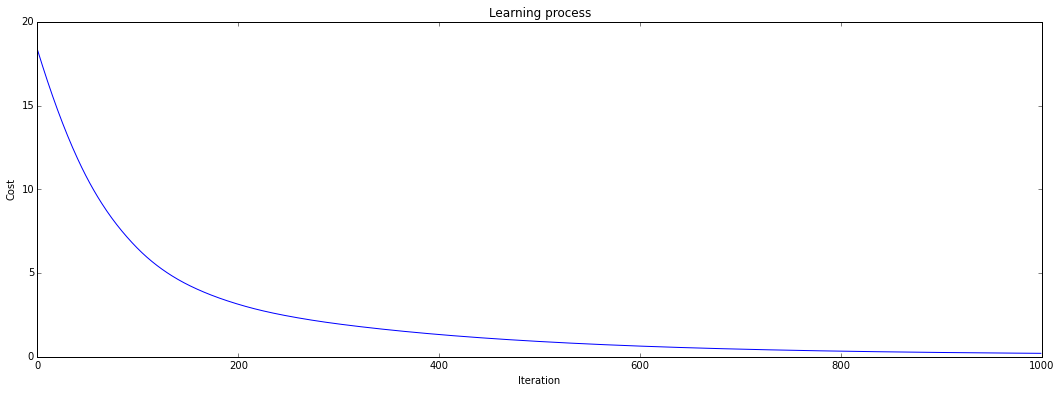

In [22]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, costs, 'b')
plt.title('Learning process')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

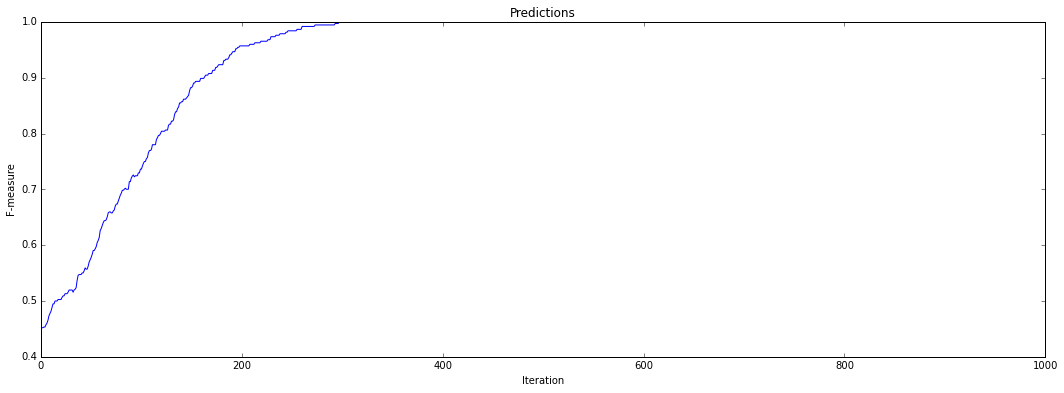

In [23]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, fmeasures, 'b')
plt.title('Predictions')
plt.xlabel("Iteration")
plt.ylabel("F-measure")
plt.show()

In [24]:
print "Final model:"
print w.get_value(), b_1.get_value()
print "target values for D: ", D[1]
print "predictions on D: ", predict(D[0])

Final model:
[  3.96125056e-02  -2.78433063e-01   9.74851602e-02  -1.62851661e-01
  -7.22345660e-02  -4.53377476e-02  -1.74393636e-01   8.91728049e-02
  -2.59957127e-02  -1.57095778e-01   8.22950716e-02  -1.62353779e-01
  -2.22365358e-02  -1.45231158e-01  -2.25931439e-01  -3.12620340e-03
   9.80954617e-02   1.48158744e-01  -1.30826520e-01  -3.68967265e-02
   2.00861036e-01  -3.17885648e-01   1.01001527e-01  -2.16679536e-02
   2.14940112e-02   1.71246054e-01  -4.26648137e-02   2.91970488e-03
  -3.42978390e-02   1.30332126e-02   1.96172282e-02   2.65601236e-02
  -7.20008659e-02  -1.57601974e-01  -1.01998443e-02   9.17017455e-02
  -1.05956622e-01  -8.25217193e-02   3.99744887e-02   1.38359825e-01
   1.09111373e-01  -2.78747464e-02   9.43293303e-04  -6.25918908e-03
  -2.17987159e-01   1.07386773e-01  -3.52409897e-02  -2.40105195e-01
  -5.36079144e-02  -1.91841735e-02  -4.45963793e-02  -1.86152559e-01
   1.60058650e-01   1.70897408e-01  -1.59280980e-01  -9.15931025e-02
  -1.66222870e-01   1

NameError: name 'b_1' is not defined

# Case study 2: Multi-Layer Perceptron


<table style="border:none;">
<tr style="border:none;">
<td style="border:none;"> 
    
<ul style="width: 450px;">
<li>Hidden layer(s)</li>
<br>
<li>Discriminative function</li>
<br>
$$ 𝑝(𝑦 = 1|𝑥) = f(w_2∙(g(w_1∙x + b_1) + b_2))$$
<br>
$f$ and $g$ can be $sigmoid/tanh$ functions
<br>
<br>
<li>Objective function</li>
<br>
Cross-entropy
<br>
$$ 𝐽 = −𝑦∙log(𝑝) − (1 − 𝑦)∙log(1 − 𝑝) $$
<br>
</ul>

</td>
<td style="border:none; width: 250px;">
    
<img src="images/multilayer.png" style="width: 200px;"> 
<img src="images/sigmoid-function.png" style="width: 200px;">

</td> 
</tr>
</table>

# Case study 2: Multi-Layer Perceptron

In [27]:
import numpy
import theano
import theano.tensor as T
rng = numpy.random

N = 400 # number of samples
feats = 784 # dimensionality of features
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
training_steps = 1000

In [28]:
# declare Theano symbolic variables
x = T.matrix('x')
y = T.vector('y')
w_1 = theano.shared(rng.randn(784,300), name='w1')
b_1 = theano.shared(numpy.zeros((300,)), name='b1')
w_2 = theano.shared(rng.randn(300), name='w2')
b_2 = theano.shared(0., name='b2')

In [29]:
print "Initial model:"
print w_1.get_value(), b_1.get_value()
print w_2.get_value(), b_2.get_value()

Initial model:
[[ 0.16753017  0.37914632 -1.36597333 ..., -1.05903447 -1.23129713
  -0.42068325]
 [ 0.18743259 -1.55847396 -0.08413758 ..., -0.04416159 -0.6613464   1.971491  ]
 [-0.49042035  1.13130496 -0.19310258 ..., -1.63863135 -0.70306244
   0.35399985]
 ..., 
 [-0.56127081  1.19272483  0.49092991 ..., -0.88355754  2.38922957
   0.19512698]
 [ 0.90678367 -1.37724433 -0.87164004 ..., -0.17850326  0.15323504
  -0.2414785 ]
 [-0.04028265 -1.67689507 -0.09370612 ...,  1.03183464  1.17336096
   1.3801636 ]] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [30]:
# Construct Theano expression graph
p_1 = T.nnet.sigmoid(-T.dot(T.nnet.sigmoid(-T.dot(x, w_1) - b_1), w_2) - b_2)
# probability that target = 1
prediction = p_1 > 0.5 # the prediction threshold
xent = -y*T.log(p_1) - (1 - y)*T.log(1 - p_1) # cross-entropy loss func
cost = xent.mean() + 0.01 * (w**2).sum() # the cost to minimize
gw_1, gb_1, gw_2, gb_2 = T.grad(cost, [w_1, b_1, w_2, b_2])

In [31]:
# Compile
train = theano.function(
    inputs = [x, y],
    outputs = [prediction, xent, cost],
    updates = 
        OrderedDict([(w_1, w_1 - 0.1*gw_1), 
                     (b_1, b_1 - 0.1*gb_1),
                     (w_2, w_2 - 0.1*gw_2),
                     (b_2, b_2 - 0.1*gb_2)
                    ]),
    allow_input_downcast=True)
predict = theano.function(
    inputs = [x], 
    outputs = prediction, 
    allow_input_downcast=True)

In [32]:
# Train
predictions = []
errors = []
costs = []
fmeasures = []

In [33]:
# Train
for i in range(training_steps):
    pred, err, cost = train(D[0], D[1])
    
    predictions.append(pred)
    errors.append(err)
    costs.append(cost)

In [34]:
# show errors
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

iterations = range(training_steps)

for i in iterations:
    fmeasures.append(f1_score(D[1], predictions[i]))

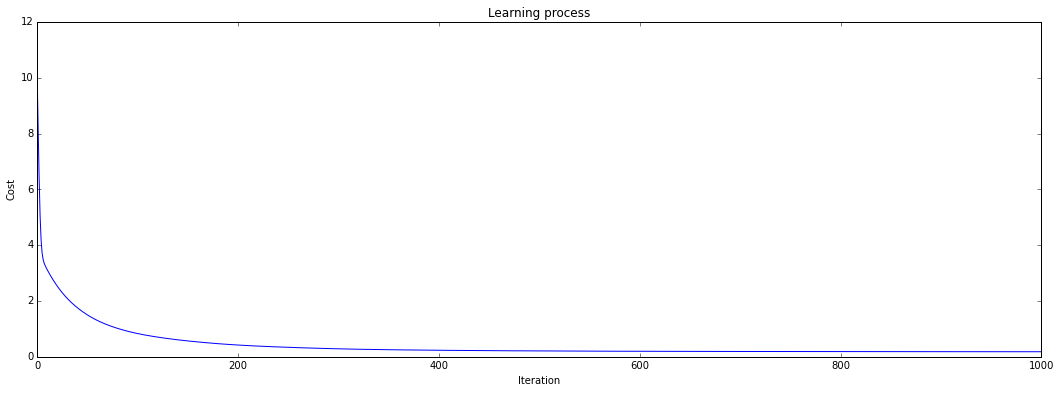

In [35]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, costs, 'b')
plt.title('Learning process')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

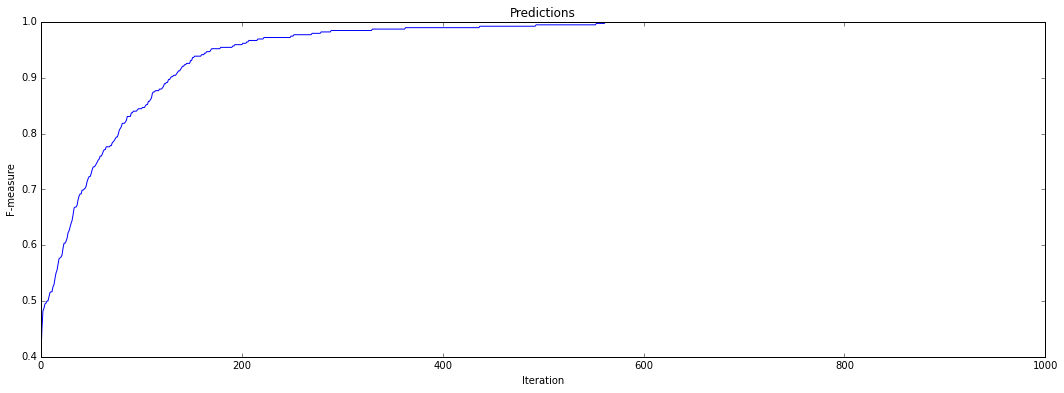

In [103]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, fmeasures, 'b')
plt.title('Predictions')
plt.xlabel("Iteration")
plt.ylabel("F-measure")
plt.show()

In [36]:
print "Final model:"
print w_1.get_value(), b_1.get_value()
print w_2.get_value(), b_2.get_value()
print "target values for D: ", D[1]
print "predictions on D: ", predict(D[0])

Final model:
[[ 0.1791781   0.36797047 -1.41090861 ..., -1.08059312 -1.24228445
  -0.41986412]
 [ 0.18935857 -1.55003229 -0.07877603 ..., -0.05212112 -0.65798339
   1.96621864]
 [-0.51138688  1.14958477 -0.21055632 ..., -1.65339444 -0.72241484
   0.34999822]
 ..., 
 [-0.56238825  1.15200913  0.54006145 ..., -0.86296181  2.39856097
   0.18304593]
 [ 0.94694669 -1.36924742 -0.88704504 ..., -0.16451224  0.15615925
  -0.23891996]
 [-0.03526568 -1.70656266 -0.08917834 ...,  1.03344667  1.16660065
   1.3923505 ]] [ -1.02289614e-02   3.40167600e-03  -7.34639322e-03   1.19536066e-02
   1.82144789e-02   9.23699476e-04  -1.38437032e-04  -3.33633362e-03
   1.53345129e-02  -9.53536665e-03   4.81083793e-03   2.42865136e-02
   1.63190670e-02   5.61957799e-04  -3.41033360e-03  -5.54428568e-03
   1.56567258e-04   3.41550987e-03  -1.17624907e-02  -9.11291661e-04
  -1.47514642e-03   1.64680129e-02   1.92766840e-02  -4.05019881e-03
   8.80865805e-04  -9.17749485e-03   4.30785453e-03   6.61531601e-03
  -1